## Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.14.0


## Load and Preprocess the Data

In a grayscale image, pixel values usually represent the brightness or intensity of the pixel. A pixel value of 0 typically corresponds to black (no intensity), and a pixel value of 255 corresponds to white (maximum intensity).
The range of pixel values is continuous, with values between 0 and 255 representing different shades of gray.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.reshape(images,[images.shape[0],images.shape[1],images.shape[2]])
        #images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("on")

##Data Type Conversion:
x_train and x_test are originally arrays of integers, representing pixel values in the range [0, 255]. The astype(np.float32) part of the code converts the data type of these arrays from integers to 32-bit floating-point numbers (float32).
This conversion is important because subsequent operations involve division, and using floating-point number.

##Scaling Pixel Values:
The converted arrays are then divided by 255.0. This operation scales the pixel values to a range between 0 and 1.
The original pixel values ranged from 0 (black) to 255 (white). Dividing all pixel values by 255 normalizes them to the range [0, 1]. After this operation, each pixel value represents the intensity of the corresponding pixel on a scale from 0 (minimum intensity) to 1 (maximum intensity).
This normalization is a form of feature scaling, and it helps in improving the performance and convergence of machine learning models, especially deep learning models like neural networks.


In [ ]:
#Fashion MNIST (generator and discriminator)

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

# images pixels 0-255 and we need to standardize it

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4422102/4422102 [==============================] - 0s 0us/step


## Create Batches of Training Data

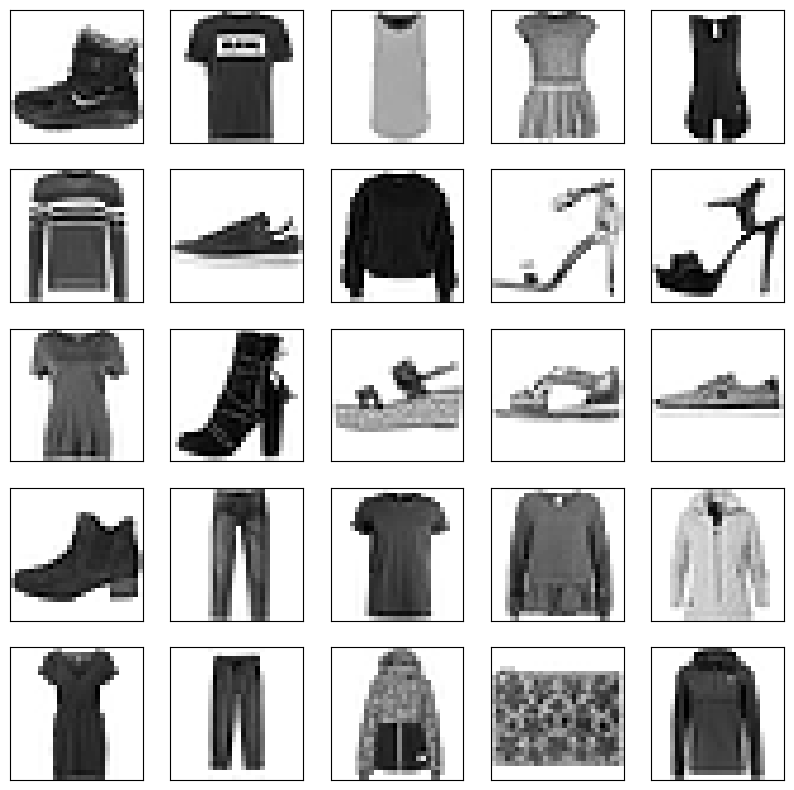

In [ ]:
#visualize some images 5 x 5 grid images using Matplotlib
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) # for gray scale
plt.show()

#Tensorflow Data creation
#Creating batches and shuffling data as it can fit in any batch of tensors

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)

#After creating the dataset, it is batched into sets of 32 elements (batch_size) with drop_remainder=True (meaning any remaining elements less than the batch size are dropped).
#Additionally, prefetch(1) is used to prefetch one batch of data, which can help to overlap data preprocessing and model execution.

dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

## Build the Generator Network for DCGAN

In [ ]:
num_features = 100 # >30 (depending upon compute power available)keras.layer

#generator model to reach 28*28*1

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 256,input_shape=[num_features]), #small DCGAN
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128,(5,5),(1,1),padding='same',activation='selu'), #selu activation and betetr for DCGANs. A fully connected layer
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding='same',activation='selu'), #selu activation and betetr for DCGANs. A fully connected layer
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2),padding='same',activation='tanh') # A fully connected layer
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                        

creating a random noise vector, passing it through a pre-trained generator model in inference mode, and then displaying the generated image. This is a common practice in GANs where random noise is used as input to the generator to produce synthetic images.


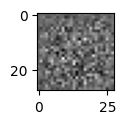

In [ ]:
# vector of random noise without being trained

noise = tf.random.normal(shape=[1,num_features])

generated_image = generator(noise,training=False)
show(generated_image,1) #plotting one such generated image

## Build the Discriminator Network for DCGAN

The first layer is a convolutional layer with 64 filters of size 5x5, a stride of 2x2, and 'same' padding. This is followed by a Leaky ReLU activation function with a leakiness of 0.2 and a dropout layer with a dropout rate of 0.3. This pattern is repeated for two more convolutional layers with increasing filter sizes (128 and 256).

In [ ]:
#discriminator model using CNN

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5),(2,2),padding='same',input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128,(5,5),(2,2),padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256,(5,5),(1,1),padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
decision = discriminator(generated_image) #check discriminator on random noise image

print(decision) #value between [0,1]

tf.Tensor([[0.5003049]], shape=(1, 1), dtype=float32)


## compile the dcgan

Optimizers are algorithms or methods that are used to update the parameters (weights and biases) of a neural network during training in order to minimize the loss function. The loss function measures how well the model is performing on a particular task, and the goal of training a neural network is to find the optimal set of parameters that minimize this loss.

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')
d_loss = BinaryCrossentropy()

discriminator.trainable = False #to train generator and discriminator separately

gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')
g_loss = BinaryCrossentropy()



In [ ]:
seed = tf.random.normal(shape=[batch_size,100]) # seed image

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# for each iteration, we will train first discriminator and then generator. For discriminator
# we will sample mini batches for discriminator from training data. Then we obtain fake images
# from random noise and in generator and then compare real images with discriminator
# We will pick gradient step for mini batches for fake and real images and update the discriminator

def train_dcgan(gan,dataset,batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)): #iteration for each epoch with tqdm - distribution of every epoch
        print('Epochs {}/{}'.format(epoch+1, epochs))
        for X_batch in dataset: #iteration for batches in dataset
            #train generator a bit
            noise = tf.random.normal(shape=[batch_size,num_features])
            generated_images = generator(noise) #pass random noise to generated to get generated image (FAKE)

            X_fake_and_real = tf.concat([generated_images, X_batch],axis=0)
            #class labels specify
            y1 = tf.constant([[0.]]*batch_size +[[1.]]*batch_size)

            discriminator.trainable = True #train discriminator
            discriminator.train_on_batch(X_fake_and_real,y1)

            y2 = tf.constant([[1.]]*batch_size) #labels for discriminator

            discriminator.trainable = False #stop discriminator training

            gan.train_on_batch(noise,y2) #training GAN

        display.clear_output(wait=True) #don't want previous output there
        generate_and_save_images(generator, epoch+1,seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

This line reshapes the training data (x_train) into a 4D tensor with dimensions (number of samples, height, width, channels). In this case, it's reshaping the Fashion MNIST images, assuming they are 28x28 pixels and have 1 channel (grayscale). The pixel values are then scaled to the range of [-1, 1].

In [ ]:
x_train_dcgan = x_train.reshape(-1,28,28, 1)*2. -1.

In [ ]:
#create batch from Fashion MNIST
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

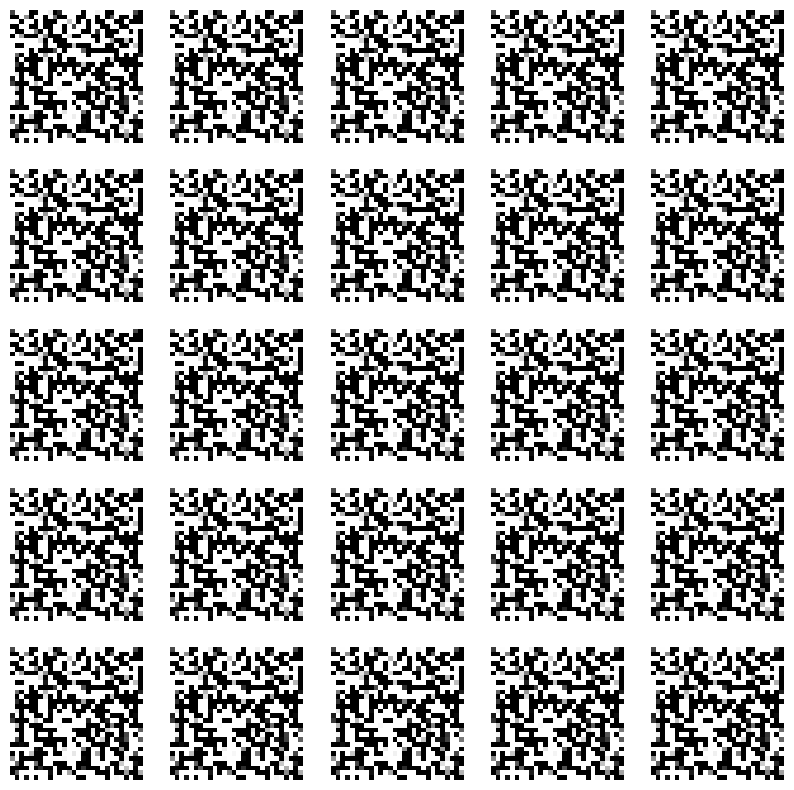

In [ ]:
#Training dcgan

hist =train_dcgan(gan,dataset,batch_size,num_features,epochs=5)

In [ ]:
import matplotlib.pyplot as plt

# Plot the discriminator and generator losses
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## Generate Synthetic Images with DCGAN

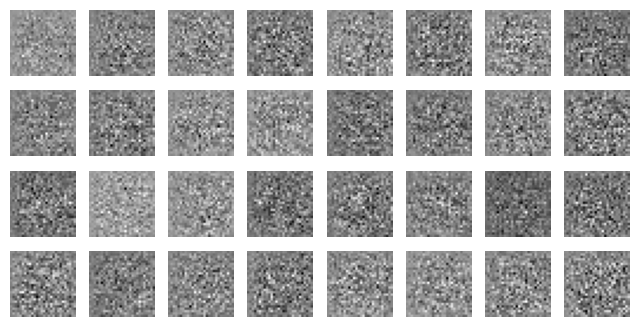

In [ ]:
noise = tf.random.normal(shape=[batch_size,num_features])
generated_images = generator(noise)

show(generated_images,8) #8 is columns

This loop iterates through the sorted filenames, and for each filename, it calculates a frame number (frame) based on the square root of the index i. It then compares the rounded value of the current frame with the rounded value of the last frame. If they differ, it reads the image from the file and appends it to the animated GIF. This mechanism ensures that frames are added to the GIF only when there is a significant change, avoiding unnecessary frames and reducing the file size.

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)

NameError: ignored